In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

2021-12-22 14:16:43.559309: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-22 14:16:44.613260: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-22 14:16:44.622096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 14:16:44.622627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.8GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-12-22 14:16:44.622651: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-22 14:16:44.624831: I tensorflow/stream_executor/platform/d

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

m/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-12-22 14:16:44.625917: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcurand.so.10
2021-12-22 14:16:44.628137: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusolver.so.11
2021-12-22 14:16:44.628769: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcusparse.so.11
2021-12-22 14:16:44.628896: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-22 14:16:44.629024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 14:16:44.629602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysF

In [2]:
#Implement a Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim=embed_dim
        self.num_heads=num_heads
        self.rate=rate
        self.ff_dim=ff_dim
    def get_config(self):
        #config = {'att': self.att,'ffn': self.ffn,'embed_dim': self.embed_dim,'num_heads': self.num_heads,'embed_dim': self.embed_dim,}  
        config = {'embed_dim': self.embed_dim,'num_heads': self.num_heads,"rate":self.rate,"ff_dim":self.ff_dim}
        base_config = super(TransformerBlock, self).get_config()  
        return dict(list(base_config.items()) + list(config.items())) 
#    def get_config(self):

#        config = super().get_config().copy()
#        config.update({
#            'att': self.att,
#            'ffn': self.ffn,
            
#        })
#        return config
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [3]:
#Implement embedding layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen=maxlen
        self.vocab_size=vocab_size
        self.embed_dim=embed_dim
    def get_config(self):
        #config = {'token_emb': self.token_emb,'pos_emb': self.pos_emb,'maxlen': self.maxlen,'vocab_size': self.vocab_size,'embed_dim': self.embed_dim}  
        config = {'maxlen': self.maxlen,'vocab_size': self.vocab_size,'embed_dim': self.embed_dim}  
        base_config = super(TokenAndPositionEmbedding, self).get_config()  
        return dict(list(base_config.items()) + list(config.items()))
#    def get_config(self):

#        config = super().get_config().copy()
#        config.update({
#            'token_emb': self.token_emb,
#            'pos_emb': self.pos_emb,
            
#        })
#        return config
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
@classmethod
def from_config(cls, config):
  return cls(**config)

In [4]:
#Download and prepare dataset
D=pd.read_table("rmPD1_ATNDDY",sep="\t")
D=D[~D.sequence.str.contains("X")]
D=D[~D.sequence.str.contains("O")]
D.shape

from numpy.random import seed
seed(1)
DtrainTemp=D.sample(frac=0.85)
Dtest=D[~D.index.isin(DtrainTemp.index)]
Dvalid=DtrainTemp.sample(frac=0.15)
Dtrain=DtrainTemp[~DtrainTemp.index.isin(Dvalid.index)]

aa_list = list('ACDEFGHIKLMNPQRSTVWY_')
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(aa_list)


# 使用分词器转化为整数序列
#seqs = ['AnNLQRn', 'TNLQR']
#seq_indices = tokenizer.texts_to_sequences(seqs)




def df_to_array(df, max_len):
    seq_indices = tokenizer.texts_to_sequences(df['sequence'])
    seq_padding = keras.preprocessing.sequence.pad_sequences(seq_indices, maxlen=max_len)
    
    X_train = seq_padding
    y_train = df['type'].to_numpy(dtype=int)
    
    return X_train, y_train
ml = np.max([len(s) for s in Dtrain['sequence']])
X_train, y_train = df_to_array(Dtrain,ml)
X_val, y_val = df_to_array(Dvalid,ml)
X_test, y_test = df_to_array(Dtest,ml)
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")
print(len(X_test), "Test sequences")
#x_train = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(x_train['sequence']), maxlen=maxlen)
#x_val = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(x_val['sequence'], maxlen=maxlen)

# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# The batch size must now be set on the Dataset objects.
batch_size = 512
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
val_data = val_data.with_options(options)

KeyboardInterrupt: 

In [6]:
Dtest

,sequence,type
5,ARLDDGYWYYDV_LSSYTTSYNMTN,0
37,ARQGSSSYNFDY_AHNPSRALPILM,0
40,AGPRGHSYGFFY_DMANTPTARPKL,0
43,ALDVGETTNIDY_ENFRFASTTDIL,0
75,ARMKFGVKVFKQ_SSSMAVAKAMGN,0
...,...,...
745157,YYWPGYPYYFDY_FYKQIMRIHQGQHIGEM,0
745166,YYYEVSYWPSWFDY_FYKQIMRIHQGQHIGEM,0
745182,YYYSGTLLQFYFDY_FYKQIMRIHQGQHIGEM,0
745183,YYYSYDYWGWFDY_FYKQIMRIHQGQHIGEM,0


In [7]:
#Create classifier model using transformer layer

vocab_size =X_train.shape[0]  # Only consider the top 20k words
maxlen = ml  # Only consider the first 200 words of each movie review

embed_dim = 21  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 21  # Hidden layer size in feed forward network inside transformer
np.random.seed(7)
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
with strategy.scope():
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.05)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.05)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model4 = keras.Model(inputs=inputs, outputs=outputs)
    model4.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
use distribute.MultiWorkerMirroredStrategy instead
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


In [8]:
#cw = {0: 1, 1:25}class_weight=cw,
history = model4.fit(
    train_data, validation_data=val_data,epochs=50)

2021-12-21 22:12:00.004273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 22:12:00.004753: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593240000 Hz


Epoch 1/50


2021-12-21 22:12:04.080451: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


   7/1049 [..............................] - ETA: 21s - loss: 0.4599 - accuracy: 0.8097   

2021-12-21 22:12:04.572432: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


1049/1049 [==============================] - 31s 25ms/step - loss: 0.1124 - accuracy: 0.9650 - val_loss: 0.0664 - val_accuracy: 0.9772
Epoch 2/50
1049/1049 [==============================] - 25s 23ms/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 0.0605 - val_accuracy: 0.9798
Epoch 3/50
1049/1049 [==============================] - 25s 23ms/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.0577 - val_accuracy: 0.9802
Epoch 4/50
1049/1049 [==============================] - 25s 23ms/step - loss: 0.0593 - accuracy: 0.9800 - val_loss: 0.0566 - val_accuracy: 0.9807
Epoch 5/50
1049/1049 [==============================] - 25s 23ms/step - loss: 0.0583 - accuracy: 0.9804 - val_loss: 0.0563 - val_accuracy: 0.9808
Epoch 6/50
1049/1049 [==============================] - 25s 23ms/step - loss: 0.0578 - accuracy: 0.9806 - val_loss: 0.0567 - val_accuracy: 0.9807
Epoch 7/50
1049/1049 [==============================] - 25s 23ms/step - loss: 0.0569 - accuracy: 0.9807 - val_loss: 0.0555 - val_accura

In [10]:
#model4.save("40X_TrueLike_model_transformer_rm.h5")

In [1]:
model4.summary()

NameError: name 'model4' is not defined

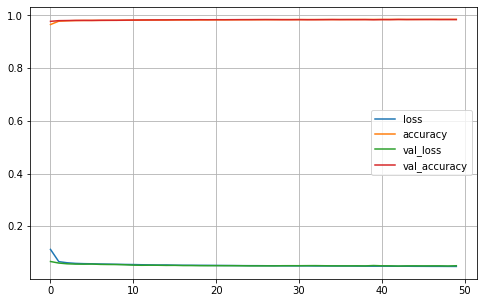

In [9]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [10]:
predict=model4.predict(X_test)
y_true=pd.Series(y_test,name="Actually")
y_predict=pd.Series(np.around(predict).reshape(111432),name="Predict")
pd.crosstab(y_true, y_predict)

2021-12-21 22:31:57.182510: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_137167"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

Predict,0.0,1.0
Actually,,
0,106284,323
1,1474,3351


In [11]:
Dtest.reset_index(drop=True,inplace=True)
Dtest["predict"]= y_predict
Dtest.to_csv("40X_Transformer_predict_TrueLike_newCDR_Epitope_token_rmPD1_ATNDDY_0.85_0.15.txt",sep="\t",index=False)

/tmp/ipykernel_18021/305533015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Dtest["predict"]= y_predict


In [12]:
#model4.save("40X_TrueLike_model_transformer_rmPD1_ATNDDY.h5")
#from keras.models import load_model
#model44=tf.keras.models.load_model("/home/cxj/CD22_DL/New/400X_TrueLike_model_transformer.h5",custom_objects={"TransformerBlock":TransformerBlock,"TokenAndPositionEmbedding":TokenAndPositionEmbedding})

In [4]:
def df_to_arrayNew(df, max_len):
    seq_indices = tokenizer.texts_to_sequences(df['sequence'])
    seq_padding = keras.preprocessing.sequence.pad_sequences(seq_indices, maxlen=max_len)
    
    X_train = seq_padding
    #y_train = df['type'].to_numpy(dtype=int)
    
    return X_train

In [ ]:
C=pd.read_table("Generate_OAS_CDR_less.Eputazu",sep="\t",header=None)
C.columns=["sequence"]

In [ ]:
ml = np.max([len(s) for s in C['sequence']])
X = df_to_arrayNew(C,45)

In [ ]:
C["predict"]=model44.predict(X)

In [ ]:
C[C.predict>0.5]

In [ ]:
C.shape

In [ ]:
C[C.predict>0.95]


Bad key text.latex.unicode in file /home/cxj/anaconda3/envs/tensorflow-gpu-py3.8/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/cxj/anaconda3/envs/tensorflow-gpu-py3.8/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/cxj/anaconda3/envs/tensorflow-gpu-py3.8/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False

NameError: name 'history' is not defined

Predict,0.0,1.0
Actually,,
0,131094,149
1,1529,3843


/home/cxj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
C=C.sort_values(by="predict",ascending=False)

In [71]:
C.to_csv("/hdd/public/cxj/zym/CD22_DL/NEWdata/40X_Transformer_GenerateOAS_epitopeTop3_predict_ALL.txt",sep="\t",index=False)

In [4]:
def df_to_arrayNew(df, max_len):
    seq_indices = tokenizer.texts_to_sequences(df['sequence'])
    seq_padding = keras.preprocessing.sequence.pad_sequences(seq_indices, maxlen=max_len)
    
    X_train = seq_padding
    #y_train = df['type'].to_numpy(dtype=int)
    
    return X_train

In [10]:
IN=pd.read_table("Epuzumab.Epitope1.txt",header=None)
IN.columns=['sequence']
IN['sequence']="ARRDITTFY_"+IN['sequence']
IN1=df_to_arrayNew(IN,45)

In [11]:
IN['predict']=model4.predict(IN1)
IN

2021-12-21 21:49:46.171387: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_140979"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

,sequence,predict
0,ARRDITTFY_PHILPPELEGRWSHGKIDTV,0.019289
1,ARRDITTFY_HILPPELEGRWSHGKIDTVQ,0.027007
2,ARRDITTFY_ILPPELEGRWSHGKIDTVQL,0.035352
3,ARRDITTFY_LPPELEGRWSHGKIDTVQLN,0.025695
4,ARRDITTFY_PPELEGRWSHGKIDTVQLNK,0.021704
5,ARRDITTFY_PELEGRWSHGKIDTVQLNKE,0.035073
6,ARRDITTFY_ELEGRWSHGKIDTVQLNKEK,0.055141
7,ARRDITTFY_LEGRWSHGKIDTVQLNKEKC,0.029323
8,ARRDITTFY_EGRWSHGKIDTVQLNKEKCE,0.051260
9,ARRDITTFY_GRWSHGKIDTVQLNKEKCEV,0.054581


In [107]:
IN['predict']=model44.predict(IN1)

In [109]:
IN=IN.sort_values(by="predict",ascending=False)
IN

,sequence,predict
16,ARRDITTFY_IDTVQLNKEKCEVSSNPEYT,0.040935
12,ARRDITTFY_SHGKIDTVQLNKEKCEVSSN,0.028387
2,ARRDITTFY_ILPPELEGRWSHGKIDTVQL,0.027804
13,ARRDITTFY_HGKIDTVQLNKEKCEVSSNP,0.026446
11,ARRDITTFY_WSHGKIDTVQLNKEKCEVSS,0.022857
0,ARRDITTFY_PHILPPELEGRWSHGKIDTV,0.022050
4,ARRDITTFY_PPELEGRWSHGKIDTVQLNK,0.020106
9,ARRDITTFY_GRWSHGKIDTVQLNKEKCEV,0.019621
7,ARRDITTFY_LEGRWSHGKIDTVQLNKEKC,0.019119
8,ARRDITTFY_EGRWSHGKIDTVQLNKEKCE,0.017864


In [5]:
#from keras.models import load_model
model44=tf.keras.models.load_model("/home/cxj/CD22_DL/New/400X_TrueLike_model_transformer.h5",custom_objects={"TransformerBlock":TransformerBlock,"TokenAndPositionEmbedding":TokenAndPositionEmbedding})

2021-12-22 14:17:06.371990: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 14:17:06.373028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 14:17:06.374218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.8GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-12-22 14:17:06.374367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but ther

In [6]:
#C1=pd.read_table("merge.dire.CDR3.uniq.deal.400x.NotUsed",sep="\t",header=None)
#C1.columns=["sequence"]
C2=pd.read_table("merge.dire.CDR3.uniq.deal.400x.NotUsed",sep="\t",header=None)
C2.columns=["sequence"]
#C3=pd.read_table("merge.dire.CDR3.uniq.deal.400x.NotUsed",sep="\t",header=None)
#C3.columns=["sequence"]

In [7]:
#C1["sequence"]=C1["sequence"]+"_IDTVQLNKEKCEVSSNPEYT"
C2["sequence"]=C2["sequence"]+"_SHGKIDTVQLNKEKCEVSSN"
#C3["sequence"]=C3["sequence"]+"_ILPPELEGRWSHGKIDTVQL"

In [8]:
aa_list = list('ACDEFGHIKLMNPQRSTVWY_')
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(aa_list)

In [9]:
#C1.loc[2000]

In [10]:
#for i in range(0,C1.shape[0],10000):
  
#    X1 = df_to_arrayNew(C1.loc[i:i+10000],45)
#    C1.loc[i:i+10000,"predict_Transformer"]=model44.predict(X1)

In [12]:
for j in range(0,C2.shape[0],10000):
    print(j)
    X2 = df_to_arrayNew(C2.loc[j:j+10000],45)
    C2.loc[j:j+10000,"predict_Transformer"]=model44.predict(X2)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

10350000
10360000
10370000
10380000
10390000
10400000
10410000
10420000
10430000
10440000
10450000
10460000
10470000
10480000
10490000
10500000
10510000
10520000
10530000
10540000
10550000
10560000
10570000
10580000
10590000
10600000
10610000
10620000
10630000
10640000
10650000
10660000
10670000
10680000
10690000
10700000
10710000
10720000
10730000
10740000
10750000
10760000
10770000
10780000
10790000
10800000
10810000
10820000
10830000
10840000
10850000
10860000
10870000
10880000
10890000
10900000
10910000
10920000
10930000
10940000
10950000
10960000
10970000
10980000
10990000
11000000
11010000
11020000
11030000
11040000
11050000
11060000
11070000
11080000
11090000
11100000
11110000
11120000
11130000
11140000
11150000
11160000
11170000
11180000
11190000
11200000
11210000
11220000
11230000
11240000
11250000
11260000
11270000
11280000
11290000
11300000
11310000
11320000
11330000
11340000
11350000
11360000
11370000
11380000
11390000
11400000
11410000
11420000
11430000
11440000
11450000
1

19460000
19470000
19480000
19490000
19500000
19510000
19520000
19530000
19540000
19550000
19560000
19570000
19580000
19590000
19600000
19610000
19620000
19630000
19640000
19650000
19660000
19670000
19680000
19690000
19700000
19710000
19720000
19730000
19740000
19750000
19760000
19770000
19780000
19790000
19800000
19810000
19820000
19830000
19840000
19850000
19860000
19870000
19880000
19890000
19900000
19910000
19920000
19930000
19940000
19950000
19960000
19970000
19980000
19990000
20000000
20010000
20020000
20030000
20040000
20050000
20060000
20070000
20080000
20090000
20100000
20110000
20120000
20130000
20140000
20150000
20160000
20170000
20180000
20190000
20200000
20210000
20220000
20230000
20240000
20250000
20260000
20270000
20280000
20290000
20300000
20310000
20320000
20330000
20340000
20350000
20360000
20370000
20380000
20390000
20400000
20410000
20420000
20430000
20440000
20450000
20460000
20470000
20480000
20490000
20500000
20510000
20520000
20530000
20540000
20550000
20560000
2

28570000
28580000
28590000
28600000
28610000
28620000
28630000
28640000
28650000
28660000
28670000
28680000
28690000
28700000
28710000
28720000
28730000
28740000
28750000
28760000
28770000
28780000
28790000
28800000
28810000
28820000
28830000
28840000
28850000
28860000
28870000
28880000
28890000
28900000
28910000
28920000
28930000
28940000
28950000
28960000
28970000
28980000
28990000
29000000
29010000
29020000
29030000
29040000
29050000
29060000
29070000
29080000
29090000
29100000
29110000
29120000
29130000
29140000
29150000
29160000
29170000
29180000
29190000
29200000
29210000
29220000
29230000
29240000
29250000
29260000
29270000
29280000
29290000
29300000
29310000
29320000
29330000
29340000
29350000
29360000
29370000
29380000
29390000
29400000
29410000
29420000
29430000
29440000
29450000
29460000
29470000
29480000
29490000
29500000
29510000
29520000
29530000
29540000
29550000
29560000
29570000
29580000
29590000
29600000
29610000
29620000
29630000
29640000
29650000
29660000
29670000
2

37680000
37690000
37700000
37710000
37720000
37730000
37740000
37750000
37760000
37770000
37780000
37790000
37800000
37810000
37820000
37830000
37840000
37850000
37860000
37870000
37880000
37890000
37900000
37910000
37920000
37930000
37940000
37950000
37960000
37970000
37980000
37990000
38000000
38010000
38020000
38030000
38040000
38050000
38060000
38070000
38080000
38090000
38100000
38110000
38120000
38130000
38140000
38150000
38160000
38170000
38180000
38190000
38200000
38210000
38220000
38230000
38240000
38250000
38260000
38270000
38280000
38290000
38300000
38310000
38320000
38330000
38340000
38350000
38360000
38370000
38380000
38390000
38400000
38410000
38420000
38430000
38440000
38450000
38460000
38470000
38480000
38490000
38500000
38510000
38520000
38530000
38540000
38550000
38560000
38570000
38580000
38590000
38600000
38610000
38620000
38630000
38640000
38650000
38660000
38670000
38680000
38690000
38700000
38710000
38720000
38730000
38740000
38750000
38760000
38770000
38780000
3

46790000
46800000
46810000
46820000
46830000
46840000
46850000
46860000
46870000
46880000
46890000
46900000
46910000
46920000
46930000
46940000
46950000
46960000
46970000
46980000
46990000
47000000
47010000
47020000
47030000
47040000
47050000
47060000
47070000
47080000
47090000
47100000
47110000
47120000
47130000
47140000
47150000
47160000
47170000
47180000
47190000
47200000
47210000
47220000
47230000
47240000
47250000
47260000
47270000
47280000
47290000
47300000
47310000
47320000
47330000
47340000
47350000
47360000
47370000
47380000
47390000
47400000
47410000
47420000
47430000
47440000
47450000
47460000
47470000
47480000
47490000
47500000
47510000
47520000
47530000
47540000
47550000
47560000
47570000
47580000
47590000
47600000
47610000
47620000
47630000
47640000
47650000
47660000
47670000
47680000
47690000
47700000
47710000
47720000
47730000
47740000
47750000
47760000
47770000
47780000
47790000
47800000
47810000
47820000
47830000
47840000
47850000
47860000
47870000
47880000
47890000
4

55900000
55910000
55920000
55930000
55940000
55950000
55960000
55970000
55980000
55990000
56000000
56010000
56020000
56030000
56040000
56050000
56060000
56070000
56080000
56090000
56100000
56110000
56120000
56130000
56140000
56150000
56160000
56170000
56180000
56190000
56200000
56210000
56220000
56230000
56240000
56250000
56260000
56270000
56280000
56290000
56300000
56310000
56320000
56330000
56340000
56350000
56360000
56370000
56380000
56390000
56400000
56410000
56420000
56430000
56440000
56450000
56460000
56470000
56480000
56490000
56500000
56510000
56520000
56530000
56540000
56550000
56560000
56570000
56580000
56590000
56600000
56610000
56620000
56630000
56640000
56650000
56660000
56670000
56680000
56690000
56700000
56710000
56720000
56730000
56740000
56750000
56760000
56770000
56780000
56790000
56800000
56810000
56820000
56830000
56840000
56850000
56860000
56870000
56880000
56890000
56900000
56910000
56920000
56930000
56940000
56950000
56960000
56970000
56980000
56990000
57000000
5

65010000
65020000
65030000
65040000
65050000
65060000
65070000
65080000
65090000
65100000
65110000
65120000
65130000
65140000
65150000
65160000
65170000
65180000
65190000
65200000
65210000
65220000
65230000
65240000
65250000
65260000
65270000
65280000
65290000
65300000
65310000
65320000
65330000
65340000
65350000
65360000
65370000
65380000
65390000
65400000
65410000
65420000
65430000
65440000
65450000
65460000
65470000
65480000
65490000
65500000
65510000
65520000
65530000
65540000
65550000
65560000
65570000
65580000
65590000
65600000
65610000
65620000
65630000
65640000
65650000
65660000
65670000
65680000
65690000
65700000
65710000
65720000
65730000
65740000
65750000
65760000
65770000
65780000
65790000
65800000
65810000
65820000
65830000
65840000
65850000
65860000
65870000
65880000
65890000
65900000
65910000
65920000
65930000
65940000
65950000
65960000
65970000
65980000
65990000
66000000
66010000
66020000
66030000
66040000
66050000
66060000
66070000
66080000
66090000
66100000
66110000
6

74120000
74130000
74140000
74150000
74160000
74170000
74180000
74190000
74200000
74210000
74220000
74230000
74240000
74250000
74260000
74270000
74280000
74290000
74300000
74310000
74320000
74330000
74340000
74350000
74360000
74370000
74380000
74390000
74400000
74410000
74420000
74430000
74440000
74450000
74460000
74470000
74480000
74490000
74500000
74510000
74520000
74530000
74540000
74550000
74560000
74570000
74580000
74590000
74600000
74610000
74620000
74630000
74640000
74650000
74660000
74670000
74680000
74690000
74700000
74710000
74720000
74730000
74740000
74750000
74760000
74770000
74780000
74790000
74800000
74810000
74820000
74830000
74840000
74850000
74860000
74870000
74880000
74890000
74900000
74910000
74920000
74930000
74940000
74950000
74960000
74970000
74980000
74990000
75000000
75010000
75020000
75030000
75040000
75050000
75060000
75070000
75080000
75090000
75100000
75110000
75120000
75130000
75140000
75150000
75160000
75170000
75180000
75190000
75200000
75210000
75220000
7

83230000
83240000
83250000
83260000
83270000
83280000
83290000
83300000
83310000
83320000
83330000
83340000
83350000
83360000
83370000
83380000
83390000
83400000
83410000
83420000
83430000
83440000
83450000
83460000
83470000
83480000
83490000
83500000
83510000
83520000
83530000
83540000
83550000
83560000
83570000
83580000
83590000
83600000
83610000
83620000
83630000
83640000
83650000
83660000
83670000
83680000
83690000
83700000
83710000
83720000
83730000
83740000
83750000
83760000
83770000
83780000
83790000
83800000
83810000
83820000
83830000
83840000
83850000
83860000
83870000
83880000
83890000
83900000
83910000
83920000
83930000
83940000
83950000
83960000
83970000
83980000
83990000
84000000
84010000
84020000
84030000
84040000
84050000
84060000
84070000
84080000
84090000
84100000
84110000
84120000
84130000
84140000
84150000
84160000
84170000
84180000
84190000
84200000
84210000
84220000
84230000
84240000
84250000
84260000
84270000
84280000
84290000
84300000
84310000
84320000
84330000
8

92340000
92350000
92360000
92370000
92380000
92390000
92400000
92410000
92420000
92430000
92440000
92450000
92460000
92470000
92480000
92490000
92500000
92510000
92520000
92530000
92540000
92550000
92560000
92570000
92580000
92590000
92600000
92610000
92620000
92630000
92640000
92650000
92660000
92670000
92680000
92690000
92700000
92710000
92720000
92730000
92740000
92750000
92760000
92770000
92780000
92790000
92800000
92810000
92820000
92830000
92840000
92850000
92860000
92870000
92880000
92890000
92900000
92910000
92920000
92930000
92940000
92950000
92960000
92970000
92980000
92990000
93000000
93010000
93020000
93030000
93040000
93050000
93060000
93070000
93080000
93090000
93100000
93110000
93120000
93130000
93140000
93150000
93160000
93170000
93180000
93190000
93200000
93210000
93220000
93230000
93240000
93250000
93260000
93270000
93280000
93290000
93300000
93310000
93320000
93330000
93340000
93350000
93360000
93370000
93380000
93390000
93400000
93410000
93420000
93430000
93440000
9

101300000
101310000
101320000
101330000
101340000
101350000
101360000
101370000
101380000
101390000
101400000
101410000
101420000
101430000
101440000
101450000
101460000
101470000
101480000
101490000
101500000
101510000
101520000
101530000
101540000
101550000
101560000
101570000
101580000
101590000
101600000
101610000
101620000
101630000
101640000
101650000
101660000
101670000
101680000
101690000
101700000
101710000
101720000
101730000
101740000
101750000
101760000
101770000
101780000
101790000
101800000
101810000
101820000
101830000
101840000
101850000
101860000
101870000
101880000
101890000
101900000
101910000
101920000
101930000
101940000
101950000
101960000
101970000
101980000
101990000
102000000
102010000
102020000
102030000
102040000
102050000
102060000
102070000
102080000
102090000
102100000
102110000
102120000
102130000
102140000
102150000
102160000
102170000
102180000
102190000
102200000
102210000
102220000
102230000
102240000
102250000
102260000
102270000
102280000
102290000


109500000
109510000
109520000
109530000
109540000
109550000
109560000
109570000
109580000
109590000
109600000
109610000
109620000
109630000
109640000
109650000
109660000
109670000
109680000
109690000
109700000
109710000
109720000
109730000
109740000
109750000
109760000
109770000
109780000
109790000
109800000
109810000
109820000
109830000
109840000
109850000
109860000
109870000
109880000
109890000
109900000
109910000
109920000
109930000
109940000
109950000
109960000
109970000
109980000
109990000
110000000
110010000
110020000
110030000
110040000
110050000
110060000
110070000
110080000
110090000
110100000
110110000
110120000
110130000
110140000
110150000
110160000
110170000
110180000
110190000
110200000
110210000
110220000
110230000
110240000
110250000
110260000
110270000
110280000
110290000
110300000
110310000
110320000
110330000
110340000
110350000
110360000
110370000
110380000
110390000
110400000
110410000
110420000
110430000
110440000
110450000
110460000
110470000
110480000
110490000


117700000
117710000
117720000
117730000
117740000
117750000
117760000
117770000
117780000
117790000
117800000
117810000
117820000
117830000
117840000
117850000
117860000
117870000
117880000
117890000
117900000
117910000
117920000
117930000
117940000
117950000
117960000
117970000
117980000
117990000
118000000
118010000
118020000
118030000
118040000
118050000
118060000
118070000
118080000
118090000
118100000
118110000
118120000
118130000
118140000
118150000
118160000
118170000
118180000
118190000
118200000
118210000
118220000
118230000
118240000
118250000
118260000
118270000
118280000
118290000
118300000
118310000
118320000
118330000
118340000
118350000
118360000
118370000
118380000
118390000
118400000
118410000
118420000
118430000
118440000
118450000
118460000
118470000
118480000
118490000
118500000
118510000
118520000
118530000
118540000
118550000
118560000
118570000
118580000
118590000
118600000
118610000
118620000
118630000
118640000
118650000
118660000
118670000
118680000
118690000


125900000
125910000
125920000
125930000
125940000
125950000
125960000
125970000
125980000
125990000
126000000
126010000
126020000
126030000
126040000
126050000
126060000
126070000
126080000
126090000
126100000
126110000
126120000
126130000
126140000
126150000
126160000
126170000
126180000
126190000
126200000
126210000
126220000
126230000
126240000
126250000
126260000
126270000
126280000
126290000
126300000
126310000
126320000
126330000
126340000
126350000
126360000
126370000
126380000
126390000
126400000
126410000
126420000
126430000
126440000
126450000
126460000
126470000
126480000
126490000
126500000
126510000
126520000
126530000
126540000
126550000
126560000
126570000
126580000
126590000
126600000
126610000
126620000
126630000
126640000
126650000
126660000
126670000
126680000
126690000
126700000
126710000
126720000
126730000
126740000
126750000
126760000
126770000
126780000
126790000
126800000
126810000
126820000
126830000
126840000
126850000
126860000
126870000
126880000
126890000


134100000
134110000
134120000
134130000
134140000
134150000
134160000
134170000
134180000
134190000
134200000
134210000
134220000
134230000
134240000
134250000
134260000
134270000
134280000
134290000
134300000
134310000
134320000
134330000
134340000
134350000
134360000
134370000
134380000
134390000
134400000
134410000
134420000
134430000
134440000
134450000
134460000
134470000
134480000
134490000
134500000
134510000
134520000
134530000
134540000
134550000
134560000
134570000
134580000
134590000
134600000
134610000
134620000
134630000
134640000
134650000
134660000
134670000
134680000
134690000
134700000
134710000
134720000
134730000
134740000
134750000
134760000
134770000
134780000
134790000
134800000
134810000
134820000
134830000
134840000
134850000
134860000
134870000
134880000
134890000
134900000
134910000
134920000
134930000
134940000
134950000
134960000
134970000
134980000
134990000
135000000
135010000
135020000
135030000
135040000
135050000
135060000
135070000
135080000
135090000


142300000
142310000
142320000
142330000
142340000
142350000
142360000
142370000
142380000
142390000
142400000
142410000
142420000
142430000
142440000
142450000
142460000
142470000
142480000
142490000
142500000
142510000
142520000
142530000
142540000
142550000
142560000
142570000
142580000
142590000
142600000
142610000
142620000
142630000
142640000
142650000
142660000
142670000
142680000
142690000
142700000
142710000
142720000
142730000
142740000
142750000
142760000
142770000
142780000
142790000
142800000
142810000
142820000
142830000
142840000
142850000
142860000
142870000
142880000
142890000
142900000
142910000
142920000
142930000
142940000
142950000
142960000
142970000
142980000
142990000
143000000
143010000
143020000
143030000
143040000
143050000
143060000
143070000
143080000
143090000
143100000
143110000
143120000
143130000
143140000
143150000
143160000
143170000
143180000
143190000
143200000
143210000
143220000
143230000
143240000
143250000
143260000
143270000
143280000
143290000


150500000
150510000
150520000
150530000
150540000
150550000
150560000
150570000
150580000
150590000
150600000
150610000
150620000
150630000
150640000
150650000
150660000
150670000
150680000
150690000
150700000
150710000
150720000
150730000
150740000
150750000
150760000
150770000
150780000
150790000
150800000
150810000
150820000
150830000
150840000
150850000
150860000
150870000
150880000
150890000
150900000
150910000
150920000
150930000
150940000
150950000
150960000
150970000
150980000
150990000
151000000
151010000
151020000
151030000
151040000
151050000
151060000
151070000
151080000
151090000
151100000
151110000
151120000
151130000
151140000
151150000
151160000
151170000
151180000
151190000
151200000
151210000
151220000
151230000
151240000
151250000
151260000
151270000
151280000
151290000
151300000
151310000
151320000
151330000
151340000
151350000
151360000
151370000
151380000
151390000
151400000
151410000
151420000
151430000
151440000
151450000
151460000
151470000
151480000
151490000


158700000
158710000
158720000
158730000
158740000
158750000
158760000
158770000
158780000
158790000
158800000
158810000
158820000
158830000
158840000
158850000
158860000
158870000
158880000
158890000
158900000
158910000
158920000
158930000
158940000
158950000
158960000
158970000
158980000
158990000
159000000
159010000
159020000
159030000
159040000
159050000
159060000
159070000
159080000
159090000
159100000
159110000
159120000
159130000
159140000
159150000
159160000
159170000
159180000
159190000
159200000
159210000
159220000
159230000
159240000
159250000
159260000
159270000
159280000
159290000
159300000
159310000
159320000
159330000
159340000
159350000
159360000
159370000
159380000
159390000
159400000
159410000
159420000
159430000
159440000
159450000
159460000
159470000
159480000
159490000
159500000
159510000
159520000
159530000
159540000
159550000
159560000
159570000
159580000
159590000
159600000
159610000
159620000
159630000
159640000
159650000
159660000
159670000
159680000
159690000


166900000
166910000
166920000
166930000
166940000
166950000
166960000
166970000
166980000
166990000
167000000
167010000
167020000
167030000
167040000
167050000
167060000
167070000
167080000
167090000
167100000
167110000
167120000
167130000
167140000
167150000
167160000
167170000
167180000
167190000
167200000
167210000
167220000
167230000
167240000
167250000
167260000
167270000
167280000
167290000
167300000
167310000
167320000
167330000
167340000
167350000
167360000
167370000
167380000
167390000
167400000
167410000
167420000
167430000
167440000
167450000
167460000
167470000
167480000
167490000
167500000
167510000
167520000
167530000
167540000
167550000
167560000
167570000
167580000
167590000
167600000
167610000
167620000
167630000
167640000
167650000
167660000
167670000
167680000
167690000
167700000
167710000
167720000
167730000
167740000
167750000
167760000
167770000
167780000
167790000
167800000
167810000
167820000
167830000
167840000
167850000
167860000
167870000
167880000
167890000


175100000
175110000
175120000
175130000
175140000
175150000
175160000
175170000
175180000
175190000
175200000
175210000
175220000
175230000
175240000
175250000
175260000
175270000
175280000
175290000
175300000
175310000
175320000
175330000
175340000
175350000
175360000
175370000
175380000
175390000
175400000
175410000
175420000
175430000
175440000
175450000
175460000
175470000
175480000
175490000
175500000
175510000
175520000
175530000
175540000
175550000
175560000
175570000
175580000
175590000
175600000
175610000
175620000
175630000
175640000
175650000
175660000
175670000
175680000
175690000
175700000
175710000
175720000
175730000
175740000
175750000
175760000
175770000
175780000
175790000
175800000
175810000
175820000
175830000
175840000
175850000
175860000
175870000
175880000
175890000
175900000
175910000
175920000
175930000
175940000
175950000
175960000
175970000
175980000
175990000
176000000
176010000
176020000
176030000
176040000
176050000
176060000
176070000
176080000
176090000


183300000
183310000
183320000
183330000
183340000
183350000
183360000
183370000
183380000
183390000
183400000
183410000
183420000
183430000
183440000
183450000
183460000
183470000
183480000
183490000
183500000
183510000
183520000
183530000
183540000
183550000
183560000
183570000
183580000
183590000
183600000
183610000
183620000
183630000
183640000
183650000
183660000
183670000
183680000
183690000
183700000
183710000
183720000
183730000
183740000
183750000
183760000
183770000
183780000
183790000
183800000
183810000
183820000
183830000
183840000
183850000
183860000
183870000
183880000
183890000
183900000
183910000
183920000
183930000
183940000
183950000
183960000
183970000
183980000
183990000
184000000
184010000
184020000
184030000
184040000
184050000
184060000
184070000
184080000
184090000
184100000
184110000
184120000
184130000
184140000
184150000
184160000
184170000
184180000
184190000
184200000
184210000
184220000
184230000
184240000
184250000
184260000
184270000
184280000
184290000


191500000
191510000
191520000
191530000
191540000
191550000
191560000
191570000
191580000
191590000
191600000
191610000
191620000
191630000
191640000
191650000
191660000
191670000
191680000
191690000
191700000
191710000
191720000
191730000
191740000
191750000
191760000
191770000
191780000
191790000
191800000
191810000
191820000
191830000
191840000
191850000
191860000
191870000
191880000
191890000
191900000
191910000
191920000
191930000
191940000
191950000
191960000
191970000
191980000
191990000
192000000
192010000
192020000
192030000
192040000
192050000
192060000
192070000
192080000
192090000
192100000
192110000
192120000
192130000
192140000
192150000
192160000
192170000
192180000
192190000
192200000
192210000
192220000
192230000
192240000
192250000
192260000
192270000
192280000
192290000
192300000
192310000
192320000
192330000
192340000
192350000
192360000
192370000
192380000
192390000
192400000
192410000
192420000
192430000
192440000
192450000
192460000
192470000
192480000
192490000


199700000
199710000
199720000
199730000
199740000
199750000
199760000
199770000
199780000
199790000
199800000
199810000
199820000
199830000
199840000
199850000
199860000
199870000
199880000
199890000
199900000
199910000
199920000
199930000
199940000
199950000
199960000
199970000
199980000
199990000
200000000
200010000
200020000
200030000
200040000
200050000
200060000
200070000
200080000
200090000
200100000
200110000
200120000
200130000
200140000
200150000
200160000
200170000
200180000
200190000
200200000
200210000
200220000
200230000
200240000
200250000
200260000
200270000
200280000
200290000
200300000
200310000
200320000
200330000
200340000
200350000
200360000
200370000
200380000
200390000
200400000
200410000
200420000
200430000
200440000
200450000
200460000
200470000
200480000
200490000
200500000
200510000
200520000
200530000
200540000
200550000
200560000
200570000
200580000
200590000
200600000
200610000
200620000
200630000
200640000
200650000
200660000
200670000
200680000
200690000


207900000
207910000
207920000
207930000
207940000
207950000
207960000
207970000
207980000
207990000
208000000
208010000
208020000
208030000
208040000
208050000
208060000
208070000
208080000
208090000
208100000
208110000
208120000
208130000
208140000
208150000
208160000
208170000
208180000
208190000
208200000
208210000
208220000
208230000
208240000
208250000
208260000
208270000
208280000
208290000
208300000
208310000
208320000
208330000
208340000
208350000
208360000
208370000
208380000
208390000
208400000
208410000
208420000
208430000
208440000
208450000
208460000
208470000
208480000
208490000
208500000
208510000
208520000
208530000
208540000
208550000
208560000
208570000
208580000
208590000
208600000
208610000
208620000
208630000
208640000
208650000
208660000
208670000
208680000
208690000
208700000
208710000
208720000
208730000
208740000
208750000
208760000
208770000
208780000
208790000
208800000
208810000
208820000
208830000
208840000
208850000
208860000
208870000
208880000
208890000


In [13]:
#for k in range(0,C3.shape[0],10000):
   
#    X3 = df_to_arrayNew(C3.loc[k:k+10000],45)
#    C3.loc[k:k+10000,"predict_Transformer"]=model44.predict(X3)

In [14]:
#C=pd.concat([C1,C2,C3],axis=0)

In [15]:
C2[C2.predict_Transformer>0.5]


,sequence,predict_Transformer
40359,AAALRYFDWLRVNNWFDP_SHGKIDTVQLNKEKCEVSSN,0.502670
40363,AAALRYFDWLYRNGWFDP_SHGKIDTVQLNKEKCEVSSN,0.534204
56783,AAAPVPYRSGSYPVDLYWFDP_SHGKIDTVQLNKEKCEVSSN,0.787874
444752,AAGGRHYDLLTGYYTRDY_SHGKIDTVQLNKEKCEVSSN,0.521190
465411,AAGILLFRLFDWVYPDY_SHGKIDTVQLNKEKCEVSSN,0.713871
...,...,...
209953688,YRGPFCSGSTYYLDY_SHGKIDTVQLNKEKCEVSSN,0.532690
209954151,YRGTQRFGGFGWLDR_SHGKIDTVQLNKEKCEVSSN,0.850993
209955232,YRLGRDYDILTGYYHPHL_SHGKIDTVQLNKEKCEVSSN,0.752110
209957217,YRSGLPGGGEWYFDD_SHGKIDTVQLNKEKCEVSSN,0.607078


In [16]:
C2[C2.predict_Transformer>0.95]

,sequence,predict_Transformer
2583634,AGAGYRLHLLERIQNWFDP_SHGKIDTVQLNKEKCEVSSN,0.978559
2967637,AGDFYRGHCAGLSCFLLDY_SHGKIDTVQLNKEKCEVSSN,0.961911
3219472,AGDPAYRYNWDEWRDTWFDP_SHGKIDTVQLNKEKCEVSSN,0.995173
3505300,AGDTAYRYNWDEWRDTWFGP_SHGKIDTVQLNKEKCEVSSN,0.993535
4729044,AGGRFLEWLGRNNWFDP_SHGKIDTVQLNKEKCEVSSN,0.976890
...,...,...
209792578,XRDLNNHGYWGWFDP_SHGKIDTVQLNKEKCEVSSN,0.984923
209801774,XRGXHILVXGVVTPFDH_SHGKIDTVQLNKEKCEVSSN,0.999119
209806768,XRQXDNDHGDPNWFDT_SHGKIDTVQLNKEKCEVSSN,0.998442
209812270,XRXGHXSGWYGRWWFDP_SHGKIDTVQLNKEKCEVSSN,0.968140


In [17]:
#

In [18]:
C2.to_csv("400X_ReallyOAS_NotUsed_predict_Transformer_C2.txt",sep="\t",index=False)